In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from datetime import datetime

In [2]:
import os
if not os.path.exists('user2movie.json') or \
   not os.path.exists('movie2user.json') or \
   not os.path.exists('usermovie2rating.json') or \
   not os.path.exists('usermovie2rating_test.json'):
   import preprocess2dict

In [3]:
with open ('user2movie.json','rb') as f:
    user2movie = pickle.load(f)
with open ('movie2user.json','rb') as f:
    movie2user = pickle.load(f)
with open ('usermovie2rating.json','rb') as f:
    usermovie2rating = pickle.load(f)
with open ('usermovie2rating_test.json','rb') as f:
    usermovie2rating_test = pickle.load(f)

In [4]:
N = np.max(list(user2movie.keys())) + 1 # number of users
m1 = np.max(list(movie2user.keys())) + 1 # number of movies
m2 = np.max([m for (u,m),r in usermovie2rating_test.items()])
M = max(m1, m2) + 1 # number of movies

In [40]:
# convert user2movie and movie2user to include ratings
user2movierating = {}
for i, movies in user2movie.items():
    r=np.array([usermovie2rating[(i,j)] for j in movies])
    user2movierating[i] = (movies, r)
movie2userating = {}
for j, users in movie2user.items():
    r=np.array([usermovie2rating[(i,j)] for i in users])
    movie2userating[j] = (users, r)    

In [41]:
#create a movie2user for test set, since we need it for loss
movie2userrating_test = {}
for (i,j), r in usermovie2rating_test.items():
  if j not in movie2userrating_test:
    movie2userrating_test[j] = [[i], [r]]
  else:
    movie2userrating_test[j][0].append(i)
    movie2userrating_test[j][1].append(r)  
for j, (users, r) in movie2userrating_test.items():
   movie2userrating_test[j][1] = np.array(r)

In [42]:
K = 10
W = np.random.randn(N,K)
b = np.zeros(N)
U = np.random.randn(M,K)
c = np.zeros(M)
mu = np.mean(list(usermovie2rating.values()))

In [43]:
def get_loss(d):
    # d: movie_id -> (user_ids, ratings)
    N = 0
    sse = 0
    for j, (users, r) in d.items():
        prediction = W[users].dot(U[j]) + b[users] + c[j] + mu
        delta = prediction-r
        sse += delta.dot(delta)
        N += len(r)
    return sse/N

In [44]:
epochs = 25
reg = 20 # regularization parameters
train_losses = []
test_losses = []

for epoch in range(epochs):
    print("epoch:", epoch)
    epoch_start = datetime.now()

    #update W and b
    t0 = datetime.now()
    for i in range(N):
        m_ids, r = user2movierating[i]
        matrix = U[m_ids].T.dot(U[m_ids]) +np.eye(K)*reg # need kxk matrix because vector will be of k dimension
        vector = (r - b[i] - c[m_ids] - mu).dot(U[m_ids]) # matrix multiplication as dot product (3,) shape as 1x3 or 3x1 according to the need
        bi = (r-c[m_ids]-U[m_ids].dot(W[i])-mu).sum() # sum of all elements in the array

        W[i] = np.linalg.solve(matrix, vector)
        b[i] = bi/(len(movies)+reg)

        if i% (N//10)==0:
            print("i:", i, "N:", N)
    print("updated W and b:", datetime.now() - t0)        

    #update U and c
    t0 = datetime.now()
    for j in range(M):
        try:
            users, r = movie2userating[j]
            matrix = W[users].T.dot(W[users]) + np.eye(K)*reg
            vector = (r-c[j]-b[users]-mu).dot(W[users]) # 1xN * NxK = 1xK (dot considers (k,) shape as 1xk or kx1 as needed)
            cj = (r-b[users]-W[users].dot(U[j])-mu).sum() # sum of all elements in the array

            U[j] = np.linalg.solve(matrix, vector)
            c[j] = cj/(len(users)+reg)

            if j% (M//10)==0:
                print("j:", j, "M:", M)
        except KeyError:
            pass        
    print("updated U and c:", datetime.now() - t0)


    # store train loss

    t0 = datetime.now()
    train_losses.append(get_loss(movie2userating))

    # store test loss

    test_losses.append(get_loss(movie2userrating_test))



epoch: 0
i: 0 N: 1000
i: 100 N: 1000
i: 200 N: 1000
i: 300 N: 1000
i: 400 N: 1000
i: 500 N: 1000
i: 600 N: 1000
i: 700 N: 1000
i: 800 N: 1000
i: 900 N: 1000
updated W and b: 0:00:00.127301
j: 0 M: 201
j: 20 M: 201
j: 40 M: 201
j: 60 M: 201
j: 80 M: 201
j: 100 M: 201
j: 120 M: 201
j: 140 M: 201
j: 160 M: 201
j: 180 M: 201
updated U and c: 0:00:00.129329
epoch: 1
i: 0 N: 1000
i: 100 N: 1000
i: 200 N: 1000
i: 300 N: 1000
i: 400 N: 1000
i: 500 N: 1000
i: 600 N: 1000
i: 700 N: 1000
i: 800 N: 1000
i: 900 N: 1000
updated W and b: 0:00:00.130522
j: 0 M: 201
j: 20 M: 201
j: 40 M: 201
j: 60 M: 201
j: 80 M: 201
j: 100 M: 201
j: 120 M: 201
j: 140 M: 201
j: 160 M: 201
j: 180 M: 201
updated U and c: 0:00:00.091683
epoch: 2
i: 0 N: 1000
i: 100 N: 1000
i: 200 N: 1000
i: 300 N: 1000
i: 400 N: 1000
i: 500 N: 1000
i: 600 N: 1000
i: 700 N: 1000
i: 800 N: 1000
i: 900 N: 1000
updated W and b: 0:00:00.129229
j: 0 M: 201
j: 20 M: 201
j: 40 M: 201
j: 60 M: 201
j: 80 M: 201
j: 100 M: 201
j: 120 M: 201
j: 140 M:

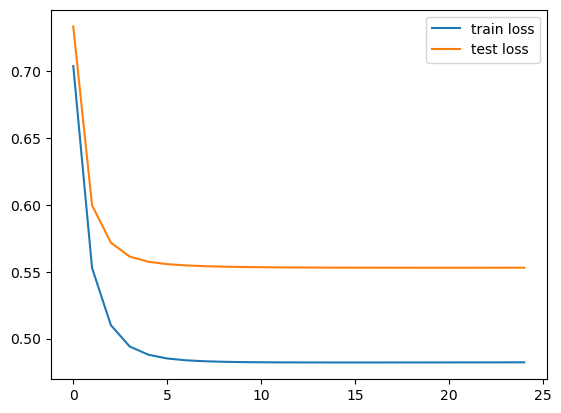

In [45]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()